In [1]:
import re
import numpy as np
import pandas as pd
import collections
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import pandas as pd
from unidecode import unidecode
from nltk.util import ngrams
from tqdm import tqdm
import time

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
permulaan = [
    'bel',
    'se',
    'ter',
    'men',
    'meng',
    'mem',
    'memper',
    'di',
    'pe',
    'me',
    'ke',
    'ber',
    'pen',
    'per',
]

hujung = ['kan', 'kah', 'lah', 'tah', 'nya', 'an', 'wan', 'wati', 'ita']

def naive_stemmer(word):
    assert isinstance(word, str), 'input must be a string'
    hujung_result = re.findall(r'^(.*?)(%s)$' % ('|'.join(hujung)), word)
    word = hujung_result[0][0] if len(hujung_result) else word
    permulaan_result = re.findall(r'^(.*?)(%s)' % ('|'.join(permulaan[::-1])), word)
    permulaan_result.extend(re.findall(r'^(.*?)(%s)' % ('|'.join(permulaan)), word))
    mula = permulaan_result if len(permulaan_result) else ''
    if len(mula):
        mula = mula[1][1] if len(mula[1][1]) > len(mula[0][1]) else mula[0][1]
    return word.replace(mula, '')

def build_dataset(words, n_words):
    count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words)
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 3)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary


def classification_textcleaning(string):
    string = re.sub(
        'http\S+|www.\S+',
        '',
        ' '.join(
            [i for i in string.split() if i.find('#') < 0 and i.find('@') < 0]
        ),
    )
    string = unidecode(string).replace('.', ' . ').replace(',', ' , ')
    string = re.sub('[^A-Za-z ]+', ' ', string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    string = ' '.join(
        [i for i in re.findall('[\\w\']+|[;:\-\(\)&.,!?"]', string) if len(i)]
    )
    string = string.lower().split()
    string = [(naive_stemmer(word), word) for word in string]
    return (
        ' '.join([word[0] for word in string if len(word[0]) > 1]),
        ' '.join([word[1] for word in string if len(word[0]) > 1]),
    )


def str_idx(corpus, dic, maxlen, UNK = 3):
    X = np.zeros((len(corpus), maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i].split()[:maxlen][::-1]):
            val = dic[k] if k in dic else UNK
            X[i, -1 - no] = val
    return X

In [3]:
df = pd.read_csv('toxic-bm.csv')
df = df.dropna()
df.shape

(40911, 7)

In [4]:
for i in range(df.shape[0]):
    df.iloc[i,0] = classification_textcleaning(df.iloc[i,0])[0]

In [5]:
texts = df.iloc[:,0].tolist()
concat = ' '.join(texts).split()
vocabulary_size = len(list(set(concat)))
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size)
print('vocab from size: %d'%(vocabulary_size))
print('Most common words', count[4:10])
print('Sample data', data[:10], [rev_dictionary[i] for i in data[:10]])

vocab from size: 55906
Most common words [('yang', 103249), ('anda', 68711), ('tidak', 54325), ('untuk', 50517), ('ada', 39335), ('saya', 32581)]
Sample data [68, 96, 78, 4, 41, 126, 276, 2584, 6129, 73] ['jelas', 'gapa', 'gedit', 'yang', 'buat', 'bawah', 'minat', 'tegar', 'tallica', 'nama']


In [6]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
Y = df[list_classes].values
Y.shape

(40911, 6)

In [7]:
class Model:
    def __init__(
        self,
        size_layer,
        num_layers,
        dimension_output,
        learning_rate,
        dropout,
        dict_size,
    ):
        def cells(size, reuse = False):
            return tf.contrib.rnn.DropoutWrapper(
                tf.nn.rnn_cell.LSTMCell(
                    size,
                    initializer = tf.orthogonal_initializer(),
                    reuse = reuse,
                ),
                state_keep_prob = dropout,
                output_keep_prob = dropout,
            )

        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.float32, [None, dimension_output])
        encoder_embeddings = tf.Variable(
            tf.random_uniform([dict_size, size_layer], -1, 1)
        )
        encoder_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.X)
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(
            num_units = size_layer, memory = encoder_embedded
        )
        rnn_cells = tf.contrib.seq2seq.AttentionWrapper(
            cell = tf.nn.rnn_cell.MultiRNNCell(
                [cells(size_layer) for _ in range(num_layers)]
            ),
            attention_mechanism = attention_mechanism,
            attention_layer_size = size_layer,
            alignment_history = True,
        )
        outputs, last_state = tf.nn.dynamic_rnn(
            rnn_cells, encoder_embedded, dtype = tf.float32
        )
        self.alignments = tf.transpose(
            last_state.alignment_history.stack(), [1, 2, 0]
        )
        W = tf.get_variable(
            'w',
            shape = (size_layer, dimension_output),
            initializer = tf.glorot_uniform_initializer(),
        )
        b = tf.get_variable(
            'b',
            shape = (dimension_output),
            initializer = tf.zeros_initializer(),
        )
        self.logits = tf.add(tf.matmul(outputs[:, -1], W), b, name = 'logits')
        self.cost = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits = self.logits, labels = self.Y
            )
        )
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.cost)
        correct_prediction = tf.equal(tf.round(tf.nn.sigmoid(self.logits)), tf.round(self.Y))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        self.attention = tf.nn.softmax(
            tf.reduce_sum(self.alignments[0], 1), name = 'alphas'
        )

In [8]:
size_layer = 256
num_layers = 2
dimension_output = Y.shape[1]
learning_rate = 1e-4
batch_size = 32
dropout = 0.8
maxlen = 80

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(
    size_layer,
    num_layers,
    dimension_output,
    learning_rate,
    dropout,
    len(dictionary),
)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'luong/model.ckpt')

'luong/model.ckpt'

In [9]:
vectors = str_idx(df.iloc[:,0].tolist(), dictionary, maxlen)
train_X, test_X, train_Y, test_Y = train_test_split(
    vectors, Y, test_size = 0.2
)

In [10]:
from tqdm import tqdm
import time

EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 3, 0, 0, 0

while True:
    lasttime = time.time()
    if CURRENT_CHECKPOINT == EARLY_STOPPING:
        print('break epoch:%d\n' % (EPOCH))
        break

    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        batch_x = train_X[i : min(i + batch_size, train_X.shape[0])]
        batch_y = train_Y[i : min(i + batch_size, train_X.shape[0])]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost, _ = sess.run(
            [model.accuracy, model.cost, model.optimizer],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        assert not np.isnan(cost)
        train_loss += cost
        train_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    pbar = tqdm(range(0, len(test_X), batch_size), desc = 'test minibatch loop')
    for i in pbar:
        batch_x = test_X[i : min(i + batch_size, test_X.shape[0])]
        batch_y = test_Y[i : min(i + batch_size, test_X.shape[0])]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost = sess.run(
            [model.accuracy, model.cost],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        test_loss += cost
        test_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    train_loss /= len(train_X) / batch_size
    train_acc /= len(train_X) / batch_size
    test_loss /= len(test_X) / batch_size
    test_acc /= len(test_X) / batch_size

    if test_acc > CURRENT_ACC:
        print(
            'epoch: %d, pass acc: %f, current acc: %f'
            % (EPOCH, CURRENT_ACC, test_acc)
        )
        CURRENT_ACC = test_acc
        CURRENT_CHECKPOINT = 0
    else:
        CURRENT_CHECKPOINT += 1

    print('time taken:', time.time() - lasttime)
    print(
        'epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'
        % (EPOCH, train_loss, train_acc, test_loss, test_acc)
    )
    EPOCH += 1


train minibatch loop:   0%|          | 1/1023 [00:00<02:57,  5.76it/s, accuracy=0.969, cost=0.0989]

epoch: 0, pass acc: 0.000000, current acc: 0.968329
time taken: 193.38855576515198
epoch: 0, training loss: 0.130981, training acc: 0.962363, valid loss: 0.104233, valid acc: 0.968329



train minibatch loop:   0%|          | 1/1023 [00:00<02:55,  5.84it/s, accuracy=0.969, cost=0.0819]

epoch: 1, pass acc: 0.968329, current acc: 0.972280
time taken: 193.38806056976318
epoch: 1, training loss: 0.092505, training acc: 0.971384, valid loss: 0.089826, valid acc: 0.972280



train minibatch loop:   0%|          | 1/1023 [00:00<02:56,  5.77it/s, accuracy=0.974, cost=0.0647]

epoch: 2, pass acc: 0.972280, current acc: 0.974248
time taken: 193.09495329856873
epoch: 2, training loss: 0.079696, training acc: 0.974246, valid loss: 0.082675, valid acc: 0.974248



train minibatch loop:   0%|          | 1/1023 [00:00<02:52,  5.93it/s, accuracy=0.974, cost=0.0647]

epoch: 3, pass acc: 0.974248, current acc: 0.974688
time taken: 192.06329321861267
epoch: 3, training loss: 0.072430, training acc: 0.975677, valid loss: 0.080014, valid acc: 0.974688



train minibatch loop:   0%|          | 1/1023 [00:00<02:55,  5.84it/s, accuracy=0.99, cost=0.0601]

time taken: 191.34756994247437
epoch: 4, training loss: 0.066932, training acc: 0.977400, valid loss: 0.078719, valid acc: 0.974573



train minibatch loop:   0%|          | 1/1023 [00:00<02:57,  5.76it/s, accuracy=0.99, cost=0.0597]

epoch: 5, pass acc: 0.974688, current acc: 0.976121
time taken: 191.28263211250305
epoch: 5, training loss: 0.062296, training acc: 0.978593, valid loss: 0.077814, valid acc: 0.976121



train minibatch loop:   0%|          | 1/1023 [00:00<02:57,  5.75it/s, accuracy=0.979, cost=0.0669]

epoch: 6, pass acc: 0.976121, current acc: 0.976244
time taken: 191.78137254714966
epoch: 6, training loss: 0.057633, training acc: 0.979971, valid loss: 0.077752, valid acc: 0.976244



train minibatch loop:   0%|          | 1/1023 [00:00<02:52,  5.92it/s, accuracy=0.984, cost=0.0581]

time taken: 192.03657364845276
epoch: 7, training loss: 0.054111, training acc: 0.980990, valid loss: 0.078399, valid acc: 0.975824



train minibatch loop:   0%|          | 1/1023 [00:00<02:56,  5.80it/s, accuracy=0.99, cost=0.064]

time taken: 191.63051748275757
epoch: 8, training loss: 0.050405, training acc: 0.981861, valid loss: 0.079810, valid acc: 0.976048



test minibatch loop: 100%|██████████| 256/256 [00:14<00:00, 16.72it/s, accuracy=1, cost=0.0102]     

time taken: 191.79751348495483
epoch: 9, training loss: 0.046325, training acc: 0.983124, valid loss: 0.080455, valid acc: 0.975681

break epoch:10



In [11]:
stack = []
pbar = tqdm(range(0, len(test_X), batch_size), desc = 'test minibatch loop')
for i in pbar:
    batch_x = test_X[i : min(i + batch_size, test_X.shape[0])]
    batch_y = test_Y[i : min(i + batch_size, test_X.shape[0])]
    stack.append(sess.run(tf.nn.sigmoid(model.logits),
                         feed_dict = {model.X: batch_x}))

test minibatch loop: 100%|██████████| 256/256 [00:35<00:00, 10.20it/s]


In [12]:
print(metrics.classification_report(test_Y,np.around(np.concatenate(stack,axis=0))))

             precision    recall  f1-score   support

          0       0.68      0.64      0.66       799
          1       0.43      0.22      0.29        81
          2       0.77      0.59      0.67       423
          3       0.57      0.16      0.25        25
          4       0.70      0.53      0.61       404
          5       0.33      0.01      0.02        81

avg / total       0.68      0.55      0.60      1813



In [13]:
import json
with open('luong-toxic.json','w') as fopen:
    fopen.write(json.dumps({'dictionary':dictionary,'reverse_dictionary':rev_dictionary}))

In [14]:
saver.save(sess, 'luong/model.ckpt')

'luong/model.ckpt'

In [15]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [16]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or 'logits' in n.name
        or 'alphas' in n.name)
        and 'Adam' not in n.name
        and 'beta' not in n.name
    ]
)

freeze_graph('luong', strings)

INFO:tensorflow:Restoring parameters from luong/model.ckpt
INFO:tensorflow:Froze 9 variables.
INFO:tensorflow:Converted 9 variables to const ops.
448 ops in the final graph.


In [17]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [19]:
g = load_graph('luong/frozen_model.pb')
x = g.get_tensor_by_name('import/Placeholder:0')
logits = g.get_tensor_by_name('import/logits:0')
alphas = g.get_tensor_by_name('import/alphas:0')
test_sess = tf.InteractiveSession(graph = g)
text = 'bodoh lah anti sosial'
new_vector = str_idx([classification_textcleaning(text)[0]], dictionary, maxlen)
test_sess.run([logits, alphas], feed_dict = {x: new_vector})

/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[array([[ 3.5956106 , -2.3644319 , -0.16097105, -2.9480898 ,  0.75664806,
         -1.8532641 ]], dtype=float32),
 array([1.8719831e-08, 1.8719831e-08, 1.8719831e-08, 1.8719831e-08,
        1.8719831e-08, 1.8719831e-08, 1.8719831e-08, 1.8719831e-08,
        1.8719831e-08, 1.8719831e-08, 1.8719831e-08, 1.8719831e-08,
        1.8719831e-08, 1.8719831e-08, 1.8719831e-08, 1.8719831e-08,
        1.8719831e-08, 1.8719831e-08, 1.8719831e-08, 1.8719831e-08,
        1.8719831e-08, 1.8719831e-08, 1.8719831e-08, 1.8719831e-08,
        1.8719831e-08, 1.8719831e-08, 1.8719831e-08, 1.8719831e-08,
        1.8719831e-08, 1.8719831e-08, 1.8719831e-08, 1.8719831e-08,
        1.8719831e-08, 1.8719831e-08, 1.8719831e-08, 1.8719831e-08,
        1.8719831e-08, 1.8719831e-08, 1.8719831e-08, 1.8719831e-08,
        1.8719831e-08, 1.8719831e-08, 1.8719831e-08, 1.8719831e-08,
        1.8719831e-08, 1.8719831e-08, 1.8719831e-08, 1.8719831e-08,
        1.8719831e-08, 1.8719831e-08, 1.8719831e-08, 1.8719831e-08,
  

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [21]:
text = classification_textcleaning(text)
new_vector = str_idx([text[0]], dictionary, len(text[0].split()))
result = test_sess.run([tf.nn.softmax(logits), alphas], feed_dict = {x: new_vector})

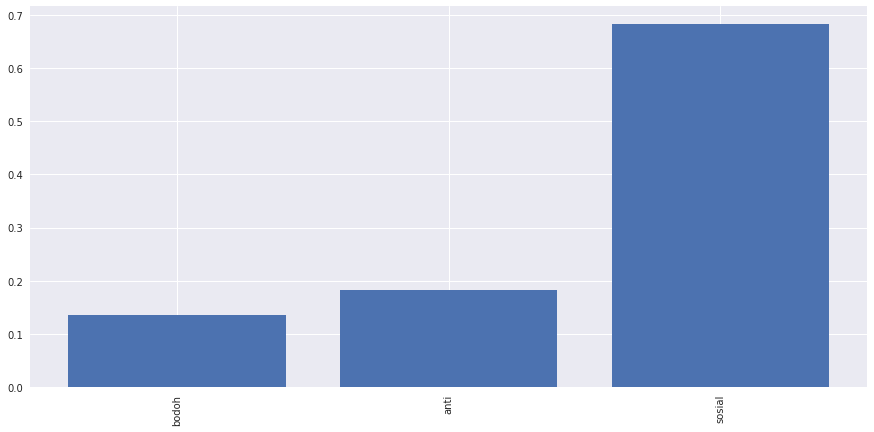

In [22]:
plt.figure(figsize = (15, 7))
labels = [word for word in text[1].split()]
val = [val for val in result[1]]
plt.bar(np.arange(len(labels)), val)
plt.xticks(np.arange(len(labels)), labels, rotation = 'vertical')
plt.show()